# Residual Package Documentation:

Theoretical information on the resdiual method for determining absolutes is available at: https://gi.copernicus.org/articles/6/419/2017/gi-6-419-2017.pdf

The residual package breaks this method into object oriented pieces that fit into the USGS geomagnetism team's process of data collection, input and calculation of absolute values. Overlying structure of the package is summarized in the following diagram.

![Residual Package Structure Diagram](../images/residual_package.png)

## Components:

Notes about underlying sytax of diagram:
* Tools are displayed as rectnagules
* Objects are displayes as ovals
* Attributes are dispayed without an encapsulating shape
* Ratio notation indicates the amount of an object contained within another object, or the amount of objects required to utilize a tool

### Tools:

#### Spreadsheet Absolutes Factory:
* Creates readings from legacy residual spreadsheets
* One spreadsheet will contain one reading, thus only one reading will result from utilizing the tool
* Allows for two types of precision: DM(degrees-minutes) or DMS(degrees-minutes-seconds)

#### Web Absolutes Factory:
* Pulls historical absolutes from the team's webservice
* Number of output readings depend on the time range specified
* Historical measurements will pertain to the Null method(no residuals, less measurements)
* Precision(DM or DMS) is determined by instrument precision specified by employees inputing observations

#### Calculation:
* Takes one reading as input and produces absolute values
* Requires that measurements contain ordinates(magnetometer readings) for each measurement excluding mark measurements
* The calculate method wraps together several helper methods to store absolutes within the input residual object

#### Calfile factory:
* Takes any number of absolutes and produces a cal file
* This method has no part in the calculation of absolutes
* Files of this format are used by data processors to produce Quasi-Definitive and Definitive data

### Objects:

#### Reading:
* Absolutes: List of 3 Absolute Objects
* Azimuth: account for location of pier(magnetic reference point for observers, optional)
* Hemisphere: 1 or -1 depending on observatory location
* Measurements: List of Measurement Objects(optional)
    * 26 Measurements for residual method
    * 12 Measurements for null method
* Metadata: defined for each observatory/set of measurements
* Pier correction: account for correction in instrument orientation(optional)
* Scale value: determined inside of calculations if not already specified(optional)

#### Measurement:
* Measurement type: Object holding supplemental information to calclulations
* Angle: Observed value from instrument
* Time: Time of observation from instrument
* Ordinates: h, e, z and f values taken from magnetometer recordings(optional, but required for calculations)

#### Measurement Type:
* String identifier of measurement category(mark up/down, north up/down, west up/down, etc.)
* Supplements for calculation:
    * Direction
    * Shift
    * Meridian
* Categorical sets
    * Mark types
    * Declination types
    * Inclination types

## Gathering Reading from Spreadsheet:

The following cell contains code to read residual measurements from a formatted spreadsheet. This is made possible through the spreadsheet absolutes factory, in which spreasheets follow the format seen within etc/residual/

Getting a Reading object consists of the following steps:

1. Initialize SpreadsheetAbsolutesFactory
2. Use factory's parse_spreadsheet method to get a reading as output
    * Requires that the user specifies a file path

In [1]:
# import factory from residual package
from geomagio.residual import SpreadsheetAbsolutesFactory

In [2]:
# initialize factory
saf = SpreadsheetAbsolutesFactory()

In [3]:
# get reading via spreadsheet parsing
reading = saf.parse_spreadsheet(path="../../etc/residual/DED-20140952332.xlsm")

## Gathering Readings from Web Absolutes

Gathering readings from the geomagnetism team's webservice is made possible through the residual package's WebAbsolutesFactory. Note that readings that are available as of November, 2020 are of the null method and not the residual method. Thus, information will be missing from these readings such as residual measurement values and additional measurements required by the residual method. Gathering readings with this tools requires two steps.

1. Initialize WebAbsolutesFactory
2. Use fac

In [4]:
# import web absolutes factory from residual package
from geomagio.residual import WebAbsolutesFactory
# import UTCDateTime from obspy for time interpretation
from obspy.core import UTCDateTime

In [5]:
# initialize factory
waf = WebAbsolutesFactory()

In [6]:
# specify required observatory, starttime, and endtime
observatory = "BOU"
starttime = UTCDateTime("2020-01-01T00:00:00Z")
endtime = UTCDateTime("2020-07-01T00:00:00Z")

readings = waf.get_readings(observatory=observatory, starttime=starttime, endtime=endtime)

It should be noted that the get_readings tool has an optional parameter called include_measurements that is turned off by default. To get readings with field measurements, one should use the code in the following cell.

In [7]:
readings = waf.get_readings(observatory=observatory, starttime=starttime, endtime=endtime, include_measurements=True)

## Calculation from Reading

The residual package's structure provides all of the supplemental information required to perform calculations. Performing calculations consist of 2 steps.

1. Isolate a reading to use for input into the calculation tool
2. Use the reading as input into the package's claculation method

In [8]:
# import calculation method from residual package
from geomagio.residual.Calculation import calculate

In [9]:
# perform calculation with reading from spreadsheet factory
output_reading = calculate(reading)

## Method Validation

The residual method utilizes fundamental theories from the null method with slight improvements to its consideration of ordinates(magnetometer readings). Note that with no existing residual measurement values, null measurements do no receive this added benefit when calculated with this package. Furthermore, resulting calculations should only vary slightly from original values.

In [10]:
# define orignal absolute and baseline arrays for each type
H_o_abs = []
H_o_baseline = []
D_o_abs = []
D_o_baseline = []
Z_o_abs = []
Z_o_baseline = []
# loop through 6 months of readings
for reading in readings:
    # append original values from null method calculations
    D_o_abs.append(reading.absolutes[0].absolute)
    D_o_baseline.append(reading.absolutes[0].baseline)
    
    H_o_abs.append(reading.absolutes[1].absolute)
    H_o_baseline.append(reading.absolutes[1].baseline)
    
    Z_o_abs.append(reading.absolutes[2].absolute)
    Z_o_baseline.append(reading.absolutes[2].baseline)

In [11]:
# import plotting tool
import matplotlib.pyplot as plt
# import numpy for fast array creation
import numpy as np

In [12]:
# define calculated absolute and baseline arrays for each type
H_c_abs = []
H_c_baseline = []
D_c_abs = []
D_c_baseline = []
Z_c_abs = []
Z_c_baseline = []
# loop through 6 months of readings
for reading in readings:
    # skip calculation if 
    try:
        reading = calculate(reading)
    except TypeError:
        D_c_abs.append(np.nan)
        D_c_baseline.append(np.nan)

        H_c_abs.append(np.nan)
        H_c_baseline.append(np.nan)

        Z_c_abs.append(np.nan)
        Z_c_baseline.append(np.nan)
        continue
    # append calculated values from null method calculations
    D_c_abs.append(reading.absolutes[0].absolute)
    D_c_baseline.append(reading.absolutes[0].baseline)
    
    H_c_abs.append(reading.absolutes[1].absolute)
    H_c_baseline.append(reading.absolutes[1].baseline)
    
    Z_c_abs.append(reading.absolutes[2].absolute)
    Z_c_baseline.append(reading.absolutes[2].baseline)
    
H_c_abs = np.array(H_c_abs)
H_c_baseline = np.array(H_c_baseline)

D_c_abs = np.array(D_c_abs)
D_c_baseline = np.array(D_c_baseline)

Z_c_abs = np.array(Z_c_abs)
Z_c_baseline = np.array(Z_c_baseline)

H_o_abs = np.array(H_o_abs)
H_o_baseline = np.array(H_o_baseline)

D_o_abs = np.array(D_o_abs)
D_o_baseline = np.array(D_o_baseline)

Z_o_abs = np.array(Z_o_abs)
Z_o_baseline = np.array(Z_o_baseline)

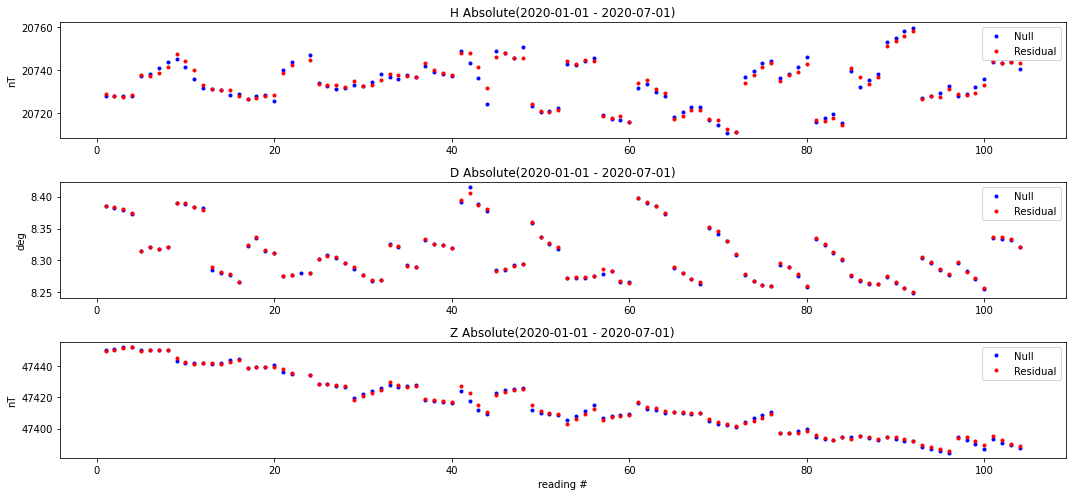

In [20]:
t = np.arange(1,len(readings)+1)

plt.figure(figsize=(15,7))

plt.subplot(3,1,1)
plt.plot(t, H_o_abs, 'b.', label="Null")
plt.plot(t, H_c_abs, 'r.', label="Residual")
plt.legend()
plt.ylabel('nT')
plt.title("H Absolute(2020-01-01 - 2020-07-01)")

plt.subplot(3,1,2)
plt.plot(t, D_o_abs, 'b.', label="Null")
plt.plot(t, D_c_abs, 'r.', label="Residual")
plt.legend()
plt.ylabel("deg")
plt.title("D Absolute(2020-01-01 - 2020-07-01)")

plt.subplot(3,1,3)
plt.plot(t, Z_o_abs, 'b.', label="Null")
plt.plot(t, Z_c_abs, 'r.', label="Residual")
plt.legend()
plt.ylabel('nT')
plt.xlabel('reading #')
plt.title("Z Absolute(2020-01-01 - 2020-07-01)")

plt.tight_layout()

plt.savefig("../images/absolute_validation.png")

plt.show()

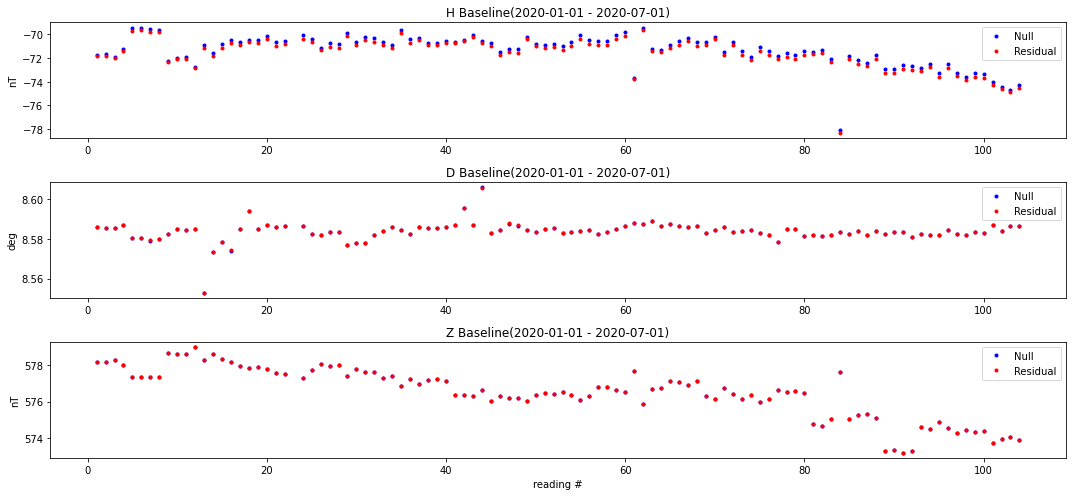

In [21]:
plt.figure(figsize=(15,7))

plt.subplot(3,1,1)
plt.plot(t, H_o_baseline, 'b.', label="Null")
plt.plot(t, H_c_baseline, 'r.', label="Residual")
plt.legend()
plt.ylabel('nT')
plt.title("H Baseline(2020-01-01 - 2020-07-01)")

plt.subplot(3,1,2)
plt.plot(t, D_o_baseline, 'b.', label="Null")
plt.plot(t, D_c_baseline, 'r.', label="Residual")
plt.legend()
plt.ylabel('deg')
plt.title("D Baseline(2020-01-01 - 2020-07-01)")

plt.subplot(3,1,3)
plt.plot(t, Z_o_baseline, 'b.', label="Null")
plt.plot(t, Z_c_baseline, 'r.', label="Residual")
plt.legend()
plt.ylabel('nT')
plt.xlabel('reading #')
plt.title("Z Baseline(2020-01-01 - 2020-07-01)")

plt.tight_layout()

plt.savefig("../images/baseline_validation.png")

plt.show()